### RQ1-1. Score Visualization (Distribution Modality Analysis)

In [ ]:
from clotho.metrics.sa import SA, FeatureSelector, PCAFeatureReducer
import clotho.dataset as clotho_dataset

from analysis_utils import load_input_hidden_states, get_test_results, target_testsuites, prompt_templates

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import rankdata

import random
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pandas as pd
import numpy as np
import os

from tqdm import tqdm

import json
import os
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import seaborn as sns
import scienceplots

plt.style.use(["science", "grid", "nature"])

plt.rcParams.update({
    "font.size": 12,           
    "axes.titlesize": 14,      
    "axes.labelsize": 12,      
    "xtick.labelsize": 10,     
    "ytick.labelsize": 10,     
    "legend.fontsize": 10,     
})

cmap = LinearSegmentedColormap.from_list("red_green", ["red", "green"], N=11)

refset_sizes = [100, 200, 300, 400, 500]
n_features = 50

target_layer_map = {
    'llama': 21,
    'gemma': 28,
    'qwen': 22
}
model = 'llama'
result_suffix = f"_{model}"
vis_dfs = []

random_seeds = [0]

mode2name = {
    'MLSA': 'Base GMM Density',
    'MDSA': 'Mahalanobis Distance (MDSA)'
}

task_alias_map = {
    "syntactic_bug_detection": "SYN-BUG",
    "spell_check": "SPELL-CHK",
    "github_typo_check": "GH-TYPO",
    "json_repair": "JSON-FIX",
    "pos_detection": "POS-TAG",
    "topic_classification": "TOPIC-CLS",
    "adding_odd_numbers": "ODD-ADD",
    "model_name_extraction": "MODEL-EX",
}

MODE = 'MDSA'
LAYER = target_layer_map[model]
tasks_to_visualize = ['json_repair', 'spell_check']
random_seeds = [0]

results_all_tasks = []
for task in tqdm(tasks_to_visualize):
    _df = pd.read_pickle(f"../clotho/results{result_suffix}/{task}/precalculated_metrics/LIH_unweighted_SA_refset_layer_{LAYER}_10_0.5.pkl")
    df_vis = _df[(_df['reference_set_size'] == 500)].copy()
    
    hidden_states = load_input_hidden_states(task, LAYER, from_variations=False, model=model)
    with open(f'../experiments/initial_tests{result_suffix}/{task}/inference_results.json', 'r') as f:
        inference_results = json.load(f)
    LIH_init = torch.load(f'../experiments/initial_tests{result_suffix}/{task}/hidden_vectors_layer_{LAYER}.pt', weights_only=False)
    LIH = np.concatenate((hidden_states, LIH_init), axis=0)

    pca = PCA(n_components=10)
    data_pca = pca.fit_transform(LIH)

    tsne = TSNE(n_components=2, random_state=42)
    data_tsne = tsne.fit_transform(data_pca)
    del hidden_states, pca, tsne, LIH, LIH_init

    df_vis['tSNE 1'] = df_vis.apply(lambda row: data_tsne[row['input_index'], 0], axis=1)
    df_vis['tSNE 2'] = df_vis.apply(lambda row: data_tsne[row['input_index'], 1], axis=1)
    df_vis['task'] = task
    results_all_tasks.append(df_vis)

df_vis = pd.concat(results_all_tasks)

100%|██████████| 2/2 [00:32<00:00, 16.35s/it]


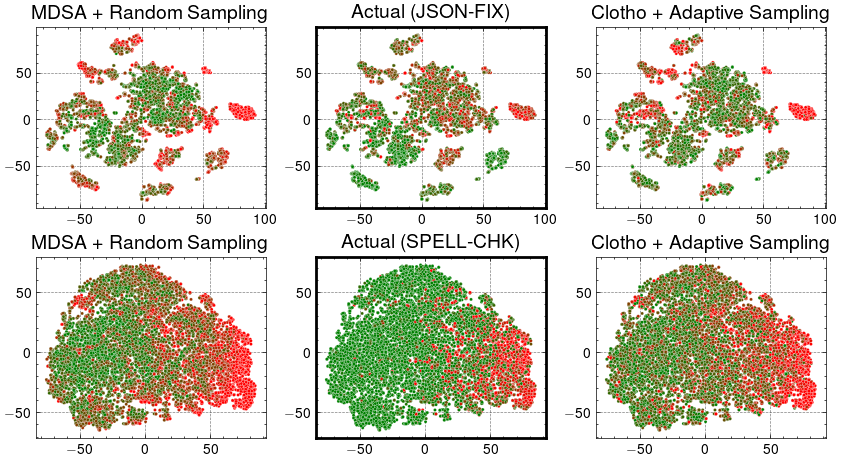

In [4]:
fig, axes = plt.subplots(ncols=3, nrows=len(tasks_to_visualize), figsize=(2.8 * 3, 2.3 * len(tasks_to_visualize)), constrained_layout=True)

for task_idx, task in enumerate(tasks_to_visualize):
    _df = pd.read_pickle(f"../clotho/results{result_suffix}/{task}/precalculated_metrics/LIH_unweighted_SA_refset_layer_{LAYER}_10_0.5.pkl")
    _df = _df[(_df['reference_set_size'] == 500)]

    subset = _df[(_df['seed'] == 0)].copy()
    subset['rank'] = rankdata(-subset[f'pred_score_{MODE}'], method='average')
    
    df_vis_subset = df_vis[(df_vis['task'] == task) & (df_vis['seed'] == 0)]
    subset = subset.merge(df_vis_subset[['input_index', 'tSNE 1', 'tSNE 2']], on='input_index', how='left')
    # display(subset.head())
    s = -subset[f'pred_score_{MODE}'].to_numpy()
    vmin, vmax = np.percentile(s, (10, 95))
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    subset['_normed'] = norm(-subset[f'pred_score_{MODE}'])

    sns.scatterplot(x='tSNE 1', y='tSNE 2', hue='_normed', data=subset, ax=axes[task_idx][0], palette=cmap, legend=None, s=5)

    axes[task_idx][0].set_title(f'MDSA + Random Sampling')
    axes[task_idx][0].set_xlabel('')
    axes[task_idx][0].set_ylabel('')

    sns.scatterplot(x='tSNE 1', y='tSNE 2', hue='test_score', data=subset, ax=axes[task_idx][1], palette=cmap, legend=None, s=5)
    axes[task_idx][1].set_title(f'Actual ({task_alias_map[task]})', fontweight='bold')
    for spine in axes[task_idx][1].spines.values():
        spine.set_linewidth(2)
        spine.set_color("black")
    axes[task_idx][1].set_xlabel('')
    axes[task_idx][1].set_ylabel('')
    
    subset = pd.read_pickle('../experiments/results_GMM/LIH_refset_iter_10{}/{}/layer_{}_seed_{}/{}_pca.pkl'.format(result_suffix, task, LAYER, 0, "balanced"))
    subset = subset[subset.iteration == 50]
    
    df_vis_subset = df_vis[(df_vis['task'] == task) & (df_vis['seed'] == 0)]
    subset = subset.merge(df_vis_subset[['input_index', 'tSNE 1', 'tSNE 2']], on='input_index', how='left')
    
    subset['rank'] = rankdata(subset['logprob'], method='average')
    s = subset[f'logprob'].to_numpy()
    vmin, vmax = np.percentile(s, (10, 95))
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    subset['_normed'] = norm(subset[f'logprob'])
    
    sns.scatterplot(x='tSNE 1', y='tSNE 2', hue='_normed', data=subset, ax=axes[task_idx][-1], palette=cmap, legend=None, s=5)

    axes[task_idx][-1].set_title(f'Clotho + Adaptive Sampling')
    axes[task_idx][-1].set_xlabel('')
    axes[task_idx][-1].set_ylabel('')

os.makedirs(f'./figures/rq1_1/', exist_ok=True)
plt.savefig(f'./figures/rq1_1/{model}_layer{LAYER}_{MODE}_clotho_comparison_vis.png')
plt.savefig(f'./figures/rq1_1/{model}_layer{LAYER}_{MODE}_clotho_comparison_vis.pdf', dpi=300)
plt.show()